In [1]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib

import numpy as np

from scipy.optimize import minimize

#use 64 bit floats
from jax.config import config; config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import jit, vmap
import jax.scipy as jsp
from functools import partial
from tqdm.auto import tqdm

from drpangloss.oifits_implaneia import load_oifits, cp_indices

from drpangloss.models import *
from drpangloss.grid_fit import *

/tmp/ipykernel_2662563/523783971.py:11: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config; config.update("jax_enable_x64", True)


In [2]:
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['font.family'] = ['serif']
plt.rcParams.update({'font.size': 14})

In [3]:
fn = "NuHor_F480M.oifits"
dr = "../data/"
oidata = OIData(*load_oifits(fn,dr))
u, v, cp, cp_err, vis2, vis2_err, i_cps1,i_cps2,i_cps3 = oidata.unpack_all()

2024-03-06 14:47:35.190485: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.3.103). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
#define a function to calculate a log likelihood grid 
inner_fun = partial(vmap(log_like_binary, in_axes=(None,None,None,None,None,None,None,None,None,0,0,None)))
outer_fun = partial(vmap(inner_fun, in_axes=(None,None,None,None,None,None,None,None,None,None,None,0)))
log_like_binary_map = jit(outer_fun)

In [5]:
#calculate ra/dec grid
dx = 5
ra_dec_grid,_ = get_grid(sep_range=[10.,600.], step_size=dx, verbose=False)
#size of grid
nx = ra_dec_grid[0].shape[0]
nb = u.shape
dra  = ra_dec_grid[0].flatten()
ddec = ra_dec_grid[1].flatten()
#number of contrasts to calculate
nconts = 100
planet_contrast = 10**np.linspace(-6,-1,nconts)

#simulate cvis data - overwrite loaded nu hor data for now
ddec_inp = 150
dra_inp = 150
simulated_data = True
p_inj_cont = 2e-4
if simulated_data:
    cvis = vis_binary(u, v, ddec=ddec_inp,dra=dra_inp,planet=p_inj_cont)
    cp = closure_phases(cvis,i_cps1,i_cps2,i_cps3)
    #add uncorrelated gaussian noise
    cp += np.random.normal(0,cp_err)
    vis2 = jnp.abs(cvis)**2
    vis2 += np.random.normal(0,vis2_err)
    d_cp = cp_err.copy()
    d_vis2 = vis2_err.copy()
else:
    d_cp = jnp.sqrt(cp_err.copy()**2+np.std(cp)**2)
    d_vis2 = jnp.sqrt(vis2_err.copy()**2+np.std(vis2)**2)



# Grid Search
Create a log likelihood map over a grid of ra, dec, contrast, with the contrast that maximizes the likelihood.

In [6]:
ll_map = log_like_binary_map(u, v, cp, d_cp, vis2, d_vis2,i_cps1,i_cps2,i_cps3, ddec,dra,planet_contrast)
#reshape likelihood map into number of contrasts , image size
ll_map_rs = ll_map.reshape(nconts,nx,nx) 
#save indices from grid fit for initialization of contrast fit
inds_cont = np.argmax(ll_map_rs,axis=0)
max_ll_map = jnp.nanmax(ll_map_rs,axis=0)
mask = 0.*max_ll_map #define an additive nan mask

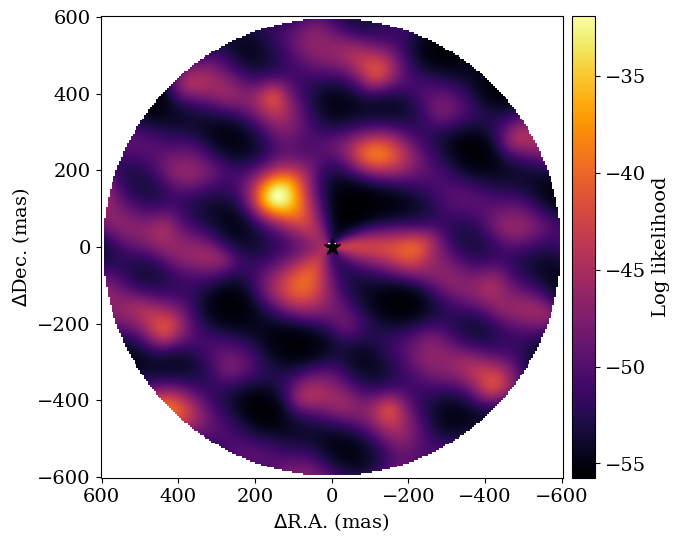

In [7]:
plt.figure(figsize=(12,6))
plt.imshow(max_ll_map,cmap='inferno',
                       extent=[dx*(nx)/2,-dx*(nx)/2,dx*(nx)/2,-dx*(nx)/2],
                       interpolation = None,alpha=1)
plt.colorbar(shrink=1,label='Log likelihood', pad=0.01)
plt.scatter(0,0,s=140,c='black',marker='*')
plt.xlabel('$\\Delta$R.A. (mas)')
plt.ylabel('$\\Delta$Dec. (mas)')
plt.gca().invert_yaxis()
plt.show()

# Use gradient based optimization to find the local minima from the grid search.

In [8]:
contrasts = optimize_log_like_map(u, v, cp, d_cp, vis2, d_vis2,i_cps1,i_cps2,i_cps3, ddec,dra,
                                  planet_contrast[inds_cont].flatten()+ mask.flatten())
contrasts_rs = contrasts.reshape(nx,nx) + mask

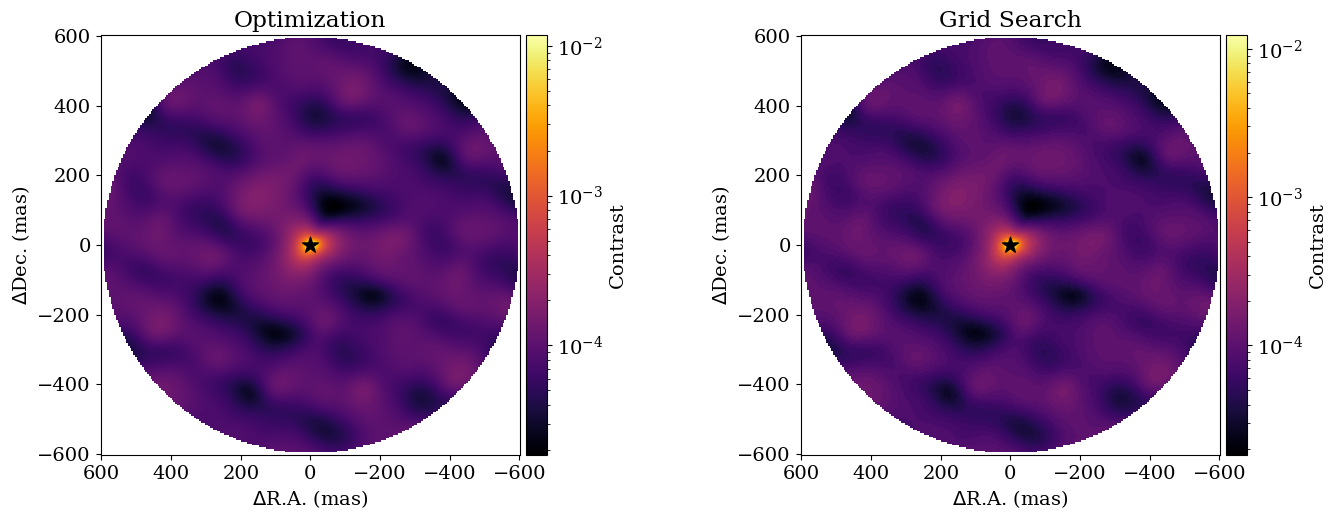

In [9]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.imshow(contrasts_rs,cmap='inferno',
                       extent=[dx*(nx)/2,-dx*(nx)/2,dx*(nx)/2,-dx*(nx)/2],
                       interpolation = None, norm=matplotlib.colors.LogNorm())
plt.colorbar(shrink=1,label='Contrast', pad=0.01)
plt.scatter(0,0,s=140,c='black',marker='*')
plt.xlabel('$\\Delta$R.A. (mas)')
plt.ylabel('$\\Delta$Dec. (mas)')
plt.title('Optimization')
plt.gca().invert_yaxis()
plt.subplot(1,2,2)
plt.imshow(planet_contrast[inds_cont]+mask,cmap='inferno',
                       extent=[dx*(nx)/2,-dx*(nx)/2,dx*(nx)/2,-dx*(nx)/2],
                       interpolation = None,alpha=1, norm=matplotlib.colors.LogNorm())
plt.colorbar(shrink=1,label='Contrast', pad=0.01)
plt.scatter(0,0,s=140,c='black',marker='*')
plt.xlabel('$\\Delta$R.A. (mas)')
plt.ylabel('$\\Delta$Dec. (mas)')
plt.title('Grid Search')
plt.gca().invert_yaxis()
plt.tight_layout(pad=0.)
plt.show()

In [10]:
#define a function to find the contrast that maximizes the log likelihood, so we are in a local minimum
#and can calculate the contrast uncertainty using the Laplace approximation.
#vmap over dec offset, ra offset and the contrasts
vmap_fun = partial(vmap(sigma, in_axes=(None,None,None,None,None,None,None,None,None,0,0,0)))
sigma_map = jit(vmap_fun)

## Laplace variances

Use the Laplace approximation to calculate the variances on the best fit contrasts in each grid cell.

In [11]:
sigmas = sigma_map(u, v, cp, d_cp, vis2, d_vis2, i_cps1,i_cps2,i_cps3, ddec, dra, contrasts_rs.flatten())
sigmas_rs = sigmas.reshape(nx,nx) + mask # reshape the uncertainty map into a grid

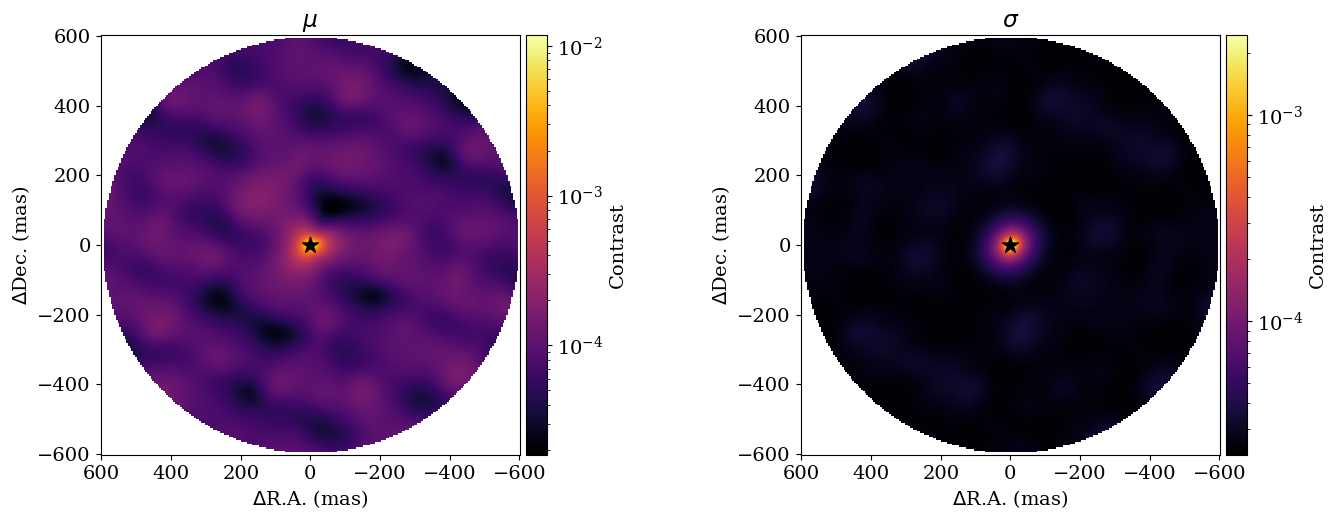

In [12]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.imshow(contrasts_rs,cmap='inferno',
                       extent=[dx*(nx)/2,-dx*(nx)/2,dx*(nx)/2,-dx*(nx)/2],
                       interpolation = None, norm=matplotlib.colors.LogNorm())
plt.colorbar(shrink=1,label='Contrast', pad=0.01)
plt.scatter(0,0,s=140,c='black',marker='*')
plt.xlabel('$\\Delta$R.A. (mas)')
plt.ylabel('$\\Delta$Dec. (mas)')
plt.title('$\\mu$')
plt.gca().invert_yaxis()
plt.subplot(1,2,2)
plt.imshow(sigmas_rs,cmap='inferno',
                       extent=[dx*(nx)/2,-dx*(nx)/2,dx*(nx)/2,-dx*(nx)/2],
                       interpolation = None,alpha=1, norm=matplotlib.colors.LogNorm())
plt.colorbar(shrink=1,label='Contrast', pad=0.01)
plt.scatter(0,0,s=140,c='black',marker='*')
plt.xlabel('$\\Delta$R.A. (mas)')
plt.ylabel('$\\Delta$Dec. (mas)')
plt.title('$\\sigma$')
plt.gca().invert_yaxis()
plt.tight_layout(pad=0.)
plt.show()

# Make an SNR map

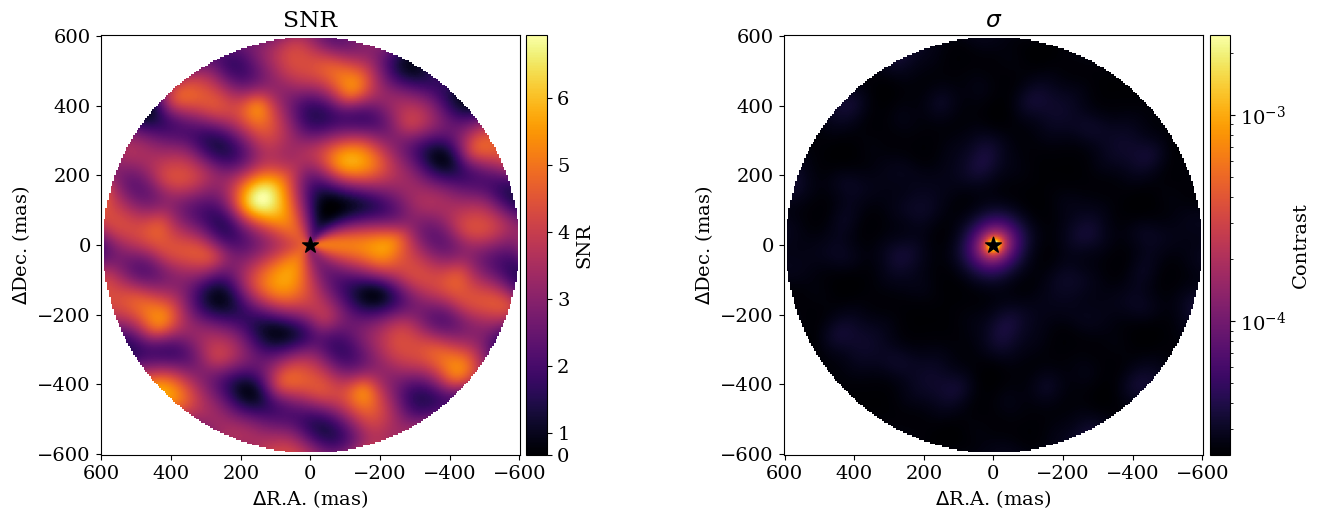

In [13]:
plt.figure(figsize=(14,5))
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['font.family'] = ['serif']
plt.rcParams.update({'font.size': 14})
plt.subplot(1,2,1)
plt.imshow(contrasts_rs/sigmas_rs,cmap='inferno',
                       extent=[dx*(nx)/2,-dx*(nx)/2,dx*(nx)/2,-dx*(nx)/2],
                       interpolation = None, norm=matplotlib.colors.PowerNorm(1))
plt.colorbar(shrink=1,label='SNR', pad=0.01)
plt.scatter(0,0,s=140,c='black',marker='*')
plt.xlabel('$\\Delta$R.A. (mas)')
plt.ylabel('$\\Delta$Dec. (mas)')
plt.title('SNR')
plt.gca().invert_yaxis()
plt.subplot(1,2,2)
plt.imshow(sigmas_rs,cmap='inferno',
                       extent=[dx*(nx)/2,-dx*(nx)/2,dx*(nx)/2,-dx*(nx)/2],
                       interpolation = None,alpha=1, norm=matplotlib.colors.LogNorm())
plt.colorbar(shrink=1,label='Contrast', pad=0.01)
plt.scatter(0,0,s=140,c='black',marker='*')
plt.xlabel('$\\Delta$R.A. (mas)')
plt.ylabel('$\\Delta$Dec. (mas)')
plt.title('$\\sigma$')
plt.gca().invert_yaxis()
plt.tight_layout(pad=0.)
plt.show()

# Calculate upper limits.

In [14]:
@partial(vmap, in_axes=(0,0,None)) # vmap over ra offset and dec offset
@partial(vmap, in_axes=(None,None,0)) # vmap over contrasts
def calc_upperlimit(mean,sigma,percentile):

    #eqn 8 from Ruffio+2018
    limit = jsp.stats.norm.ppf((percentile+(1-percentile)*jsp.stats.norm.cdf(0,loc=mean,scale=sigma)),loc=mean,scale=sigma)

    return limit

In [15]:
#calculate the upper limit from the found contrasts and uncertainties using the Ruffio method
nsig = 2. # calculate the 2 sigma equivalent upper limit
perc = jnp.array([jsp.stats.norm.cdf(nsig)])
limits = calc_upperlimit(contrasts_rs.flatten(),sigmas_rs.flatten(),perc)
limits_rs = limits.reshape(nx,nx,perc.shape[0])
#azimuthally average the limit map
rad_wdith, avg_wdith  = azimuthalAverage(-2.5*np.log10(limits_rs[:,:,0]), returnradii=True, binsize=2, stddev=False)
_, std_wdith  = azimuthalAverage(-2.5*np.log10(limits_rs[:,:,0]), returnradii=True, binsize=2, stddev=True)

/home/dori/anaconda3/envs/ami/lib/python3.11/site-packages/drpangloss/grid_fit.py:131: RuntimeWarning: invalid value encountered in scalar divide
  radial_prof = np.array([(image*weights).flat[whichbin==b].sum() / weights.flat[whichbin==b].sum() for b in range(1,nbins+1)])
/home/dori/anaconda3/envs/ami/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dori/anaconda3/envs/ami/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dori/anaconda3/envs/ami/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


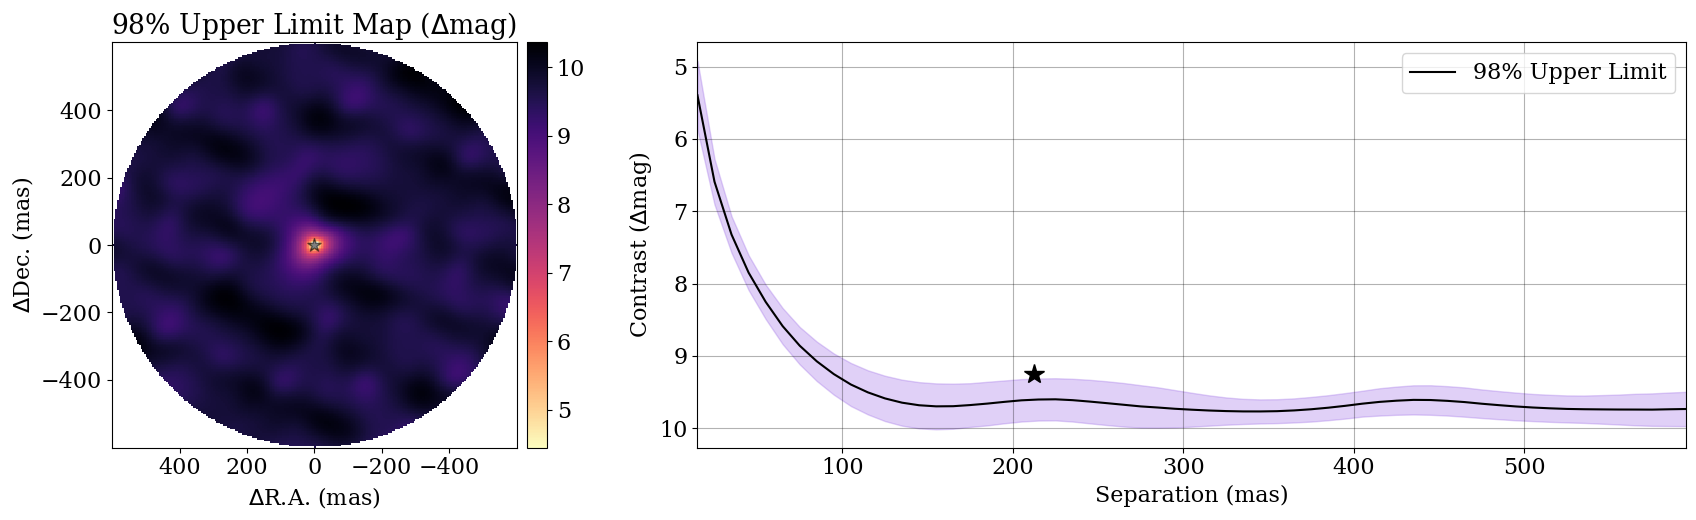

In [16]:
plt.figure(figsize=(20,5))
matplotlib.rcParams['figure.dpi'] = 150
matplotlib.rcParams['font.family'] = ['serif']
plt.rcParams.update({'font.size': 16})
plt.subplot(1,2,1)
plt.imshow(-2.5*jnp.log10(limits_rs[:,:,-1]),cmap=matplotlib.colormaps['magma_r'],
                       extent=[dx*(nx)/2,-dx*(nx)/2,dx*(nx)/2,-dx*(nx)/2],
                       interpolation = 'None',alpha=1)
plt.colorbar(shrink=1, pad=0.01)
plt.scatter(0,0,marker='*',s=100,c='black',alpha=0.5)
plt.gca().invert_yaxis()
plt.title('98% Upper Limit Map ($\\Delta$mag)')
plt.xlabel('$\\Delta$R.A. (mas)')
plt.ylabel('$\\Delta$Dec. (mas)')
plt.xticks([400,200,0,-200,-400])
plt.yticks([-400,-200,0,200,400])
plt.subplot(1,2,2)
plt.plot(rad_wdith*dx,avg_wdith,'-k',label="98% Upper Limit")
plt.fill_between(rad_wdith*dx,avg_wdith - std_wdith,avg_wdith + std_wdith,color=(0.6,0.4,0.9),alpha=0.3)
plt.ylabel('Contrast ($\\Delta$mag)')
plt.xlabel('Separation (mas)')
plt.gca().invert_yaxis()
plt.xlim(np.nanmin(rad_wdith*dx+avg_wdith*0.),np.nanmax(rad_wdith*dx+avg_wdith*0.))
plt.grid(color='black',alpha=0.3)
plt.legend(loc='best')
plt.tight_layout(pad=0.)
plt.plot(jnp.sqrt(ddec_inp**2+dra_inp**2),-2.5*jnp.log10(p_inj_cont),marker='*',c='k',markersize=15)
plt.show()

In [17]:
#code used to generate the ppf array
#size = 10_000_000
#xs = np.logspace(-15,0,size)
#ppf_arr = np.zeros(size)
#for i in tqdm(range(size)):
#    ppf_arr[i] = stats.chi2.ppf(1-xs[i],1)
#np.save("chi2_ppf", ppf_arr)
#np.save("chi2_ppf_xs", xs)

In [18]:
#load precalculated pff array and p-values to interpolate over
ppf_arr = np.load("../data/chi2_ppf.npy")
xs = np.load("../data/chi2_ppf_xs.npy")

In [19]:
#define a function to find the contrast that finds the squared difference between the calculated nsigma significance and the desired nsigma
#uses eqn 3 from Absil 2011
#vmap over contrast, dec offset, ra offset
vmap_fun = partial(vmap(optimize_nsigma, in_axes=(None,None,None,None,None,None,None,None,None,0,0,0,None,None,None,None)))
optimize_nsigma_map = jit(vmap_fun)

In [20]:
#define a function used to calculate a contrast limit grid 
#vmap over dec offset, ra offset
inner_fun = partial(vmap(nsigma_wrap, in_axes=(None,None,None,None,None,None,None,None,None,None,0,0,None,None,None,None)))
#vmap over contrast
outer_fun = partial(vmap(inner_fun, in_axes=(0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None)))
nsigma_wrap_map = jit(outer_fun)

In [21]:
ndof = len(cp.flatten())+len(vis2.flatten()) #degrees of freedom
sigma = 2. #nsigma for contrast limit level

#use this if not using simulated data
#nsigma_map = nsigma_wrap_map(planet_contrast, *oidata.unpack_all(), ddec,dra,jnp.array(xs),jnp.array(ppf_arr),ndof,sigma)

#use this for simulated data
#calculate grid over contrast, ddec, dra
nsigma_map = nsigma_wrap_map(planet_contrast, u, v, cp, d_cp, vis2, d_vis2,i_cps1,i_cps2,i_cps3, ddec,dra,jnp.array(xs),jnp.array(ppf_arr),ndof,sigma)

#reshape nsigma map into number of contrasts, image size
nsigma_map_rs = nsigma_map.reshape(nconts,nx,nx) 
#find indices from grid search that minimize difference between calculated nsigma and desired nsigma for initialization of nsigma fit
inds_cont_ns = np.argmin(nsigma_map_rs,axis=0)
min_nsigma_map = jnp.nanmin(nsigma_map_rs,axis=0)
mask = 0.*min_nsigma_map #define an additive nan mask

In [22]:
#find the contrast that gives the desired number of sigma signifcance between a binary model and a single star model
limits = optimize_nsigma_map(u, v, cp, d_cp, vis2, d_vis2,i_cps1,i_cps2,i_cps3, ddec,dra,
                                  (jnp.clip(planet_contrast[inds_cont_ns].flatten()+ mask.flatten(),a_min=0,a_max=None)+1e-9),
                                  jnp.array(xs),jnp.array(ppf_arr),ndof,sigma)
limits_rs = limits.reshape(nx,nx) + mask

In [23]:
#impose constraints on the contrasts used for the contrast limits - this is because optimistix only has bfgs (unconstrained)
#this should not be an issue because we initialize the gradient descent very close to the local minima with the initial grid seach
limits_rs = jnp.where(limits_rs<1e-6,1e-6,limits_rs) # lower limit 1e-6
limits_rs = jnp.where(limits_rs>1.,1.,limits_rs) #upper limit of 1 (companion = star)

In [24]:
#azimuthally average the derived contrast limits
rad_wdith, avg_wdith  = azimuthalAverage(-2.5*np.log10(limits_rs[:,:]), returnradii=True, binsize=2, stddev=False)
_, std_wdith  = azimuthalAverage(-2.5*np.log10(limits_rs[:,:]), returnradii=True, binsize=2, stddev=True)

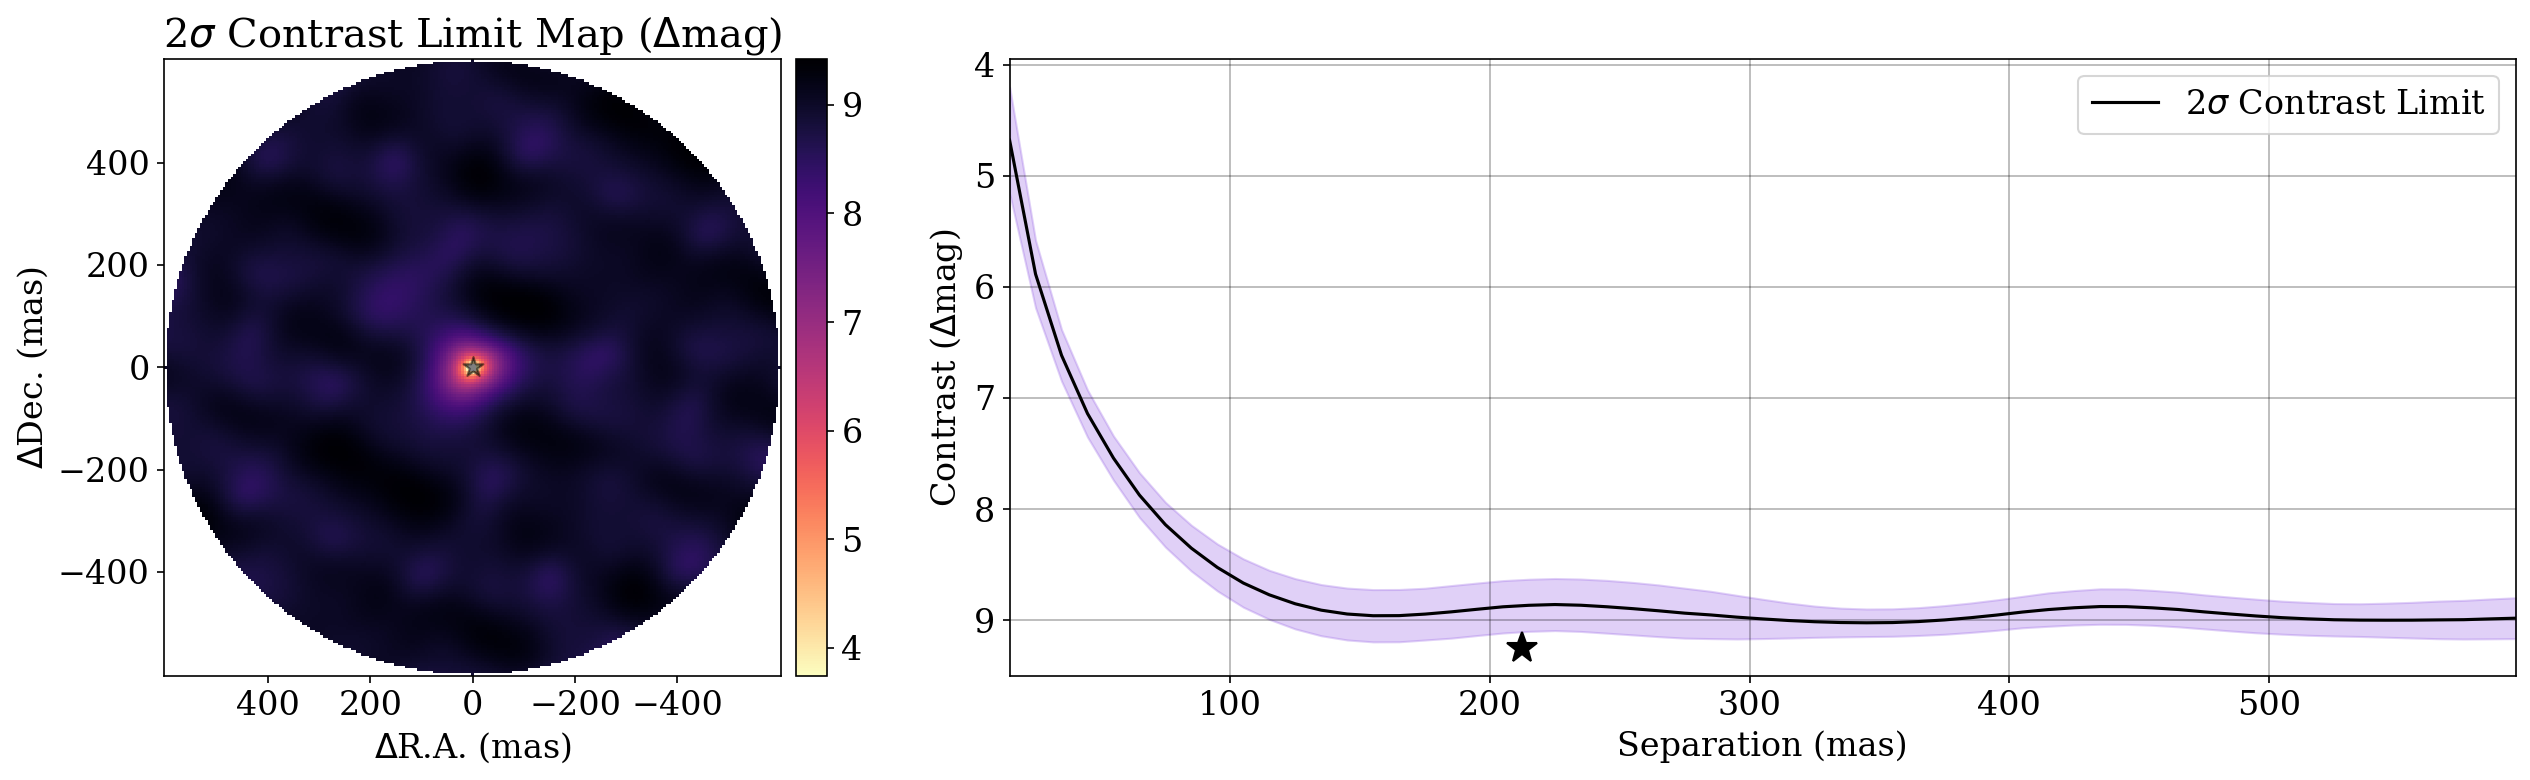

In [25]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.imshow(-2.5*jnp.log10(limits_rs[:,:]),cmap=matplotlib.colormaps['magma_r'],
                       extent=[dx*(nx)/2,-dx*(nx)/2,dx*(nx)/2,-dx*(nx)/2],
                       interpolation = 'None',alpha=1)
plt.colorbar(shrink=1, pad=0.01)
plt.scatter(0,0,marker='*',s=100,c='black',alpha=0.5)
plt.gca().invert_yaxis()
plt.title('2$\sigma$ Contrast Limit Map ($\\Delta$mag)')
plt.xlabel('$\\Delta$R.A. (mas)')
plt.ylabel('$\\Delta$Dec. (mas)')
plt.xticks([400,200,0,-200,-400])
plt.yticks([-400,-200,0,200,400])
plt.subplot(1,2,2)
plt.plot(rad_wdith*dx,avg_wdith,'-k',label="2$\sigma$ Contrast Limit")
plt.fill_between(rad_wdith*dx,avg_wdith - std_wdith,avg_wdith + std_wdith,color=(0.6,0.4,0.9),alpha=0.3)
plt.ylabel('Contrast ($\\Delta$mag)')
plt.xlabel('Separation (mas)')
plt.gca().invert_yaxis()
plt.xlim(np.nanmin(rad_wdith*dx+avg_wdith*0.),np.nanmax(rad_wdith*dx+avg_wdith*0.))
plt.grid(color='black',alpha=0.3)
plt.legend(loc='best')
plt.tight_layout(pad=0.)
plt.plot(jnp.sqrt(ddec_inp**2+dra_inp**2),-2.5*jnp.log10(p_inj_cont),marker='*',c='k',markersize=15)
plt.show()